<a name="top" id="top"></a>

<div align="center">
    <h1>Benchmarking</h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <i>Universities Space Research Association</i>
    <br>
    <i>NASA QuAIL</i>
    <br>
    <br>
    <a href="https://github.com/pedromxavier">Pedro Maciel Xavier</a>
    <br>
    <i>Computer Science &amp; Systems Engineering Program, Federal University of Rio de Janeiro</i>
    <br>
    <i>PSR Energy Consulting &amp; Analytics</i>
    <br>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/QUBONotebooks/blob/main/notebooks/2-QUBO.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="#installation">
        <img src="https://img.shields.io/badge/⚙️-Installation_Instructions-blue" alt="Installation Instructions"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

### Activate Environment

In [1]:
import Pkg; Pkg.activate(@__DIR__) # Here we go!

  Activating project at `/mnt/c/Users/pedroxavier/QUBONotebooks/notebooks`


## About this Notebook

With the new availability of unconventional hardware, novel algorithms, and increasingly optimized software to address optimization problems; the first question that arises is, which one is better?
We will call the combination of hardware, algorithm, and software within a solution method as a solver.
This question is also relevant when evaluating a single solver, given that usually they rely on hyperparameters, for which the quesiton now becomes into, which is the best parameter setting for a given solver?
These questions obviously depend on the problem that one is trying to solve. The solution of the problem also depends on the budget of resources that one has available.

In the case that the available resources are relatively "unlimited" and that the problem to solve is known, one could exhaustively try all the parameter settings within a delimited range for that instance and choose which one is the best.
This case is idealistic, in the sense that usually one does not know a-priori which problem is there to solve (and if while testing all the parameters you solve it, what would be the point of identifying the best parameters?), and that there exists limitations in terms of resources, e.g., time, memory, or energy, when trying to address these problems.
A case closer to reality is where you have the chance of solving problems that look similar to the one that you are interested in solving later, either because you have previously generated problems or you have identified a feature that characterizes your problem of interest and can generate random instances, which we will call as a family of instances.
Then, you can use a larger amount of resources to solve that family of problems "off-line", meaning that you spend extra resources to address the problems in your family of instances although it is unrelated to the actual application.
Finally, you would like to use the results that you found off-line as a guidance to solve your unknown problem more efficiently.

## Example
For illustration purposes, we will use an example that you are already familiar with, which is an Ising model.
As a solver, we will use the **[PySA](https://github.com/nasa/pysa)** simulated annealing code.

## Ising model
This notebook will explain the basics of the Ising model.
In order to implement the different Ising Models we will use **[JuMP](https://jump.dev)** and **[QUBO.jl](https://github.com/psrenergy/QUBO.jl)**, for defining the Ising model and solving it with simulated annealing.

### Problem statement

We pose the Ising problem as the following optimization problem:

$$
\min_{s \in \{ \pm 1 \}^n} H(s) = \min_{s \in \{ \pm 1 \}^n} \sum_{(i, j) \in E(G)} J_{i,j}s_is_j + \sum_{i \in V(G)} h_is_i + \beta
$$

where we optimize over spins $s \in \{ \pm 1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{i,j}$ and the linear coefficients are $h_i$.
We also include an arbitrary offset of the Ising model $\beta$.

### Example 1

Suppose we have an Ising model defined from

$$
h = \begin{bmatrix}
145.0 \\ 122.0 \\ 122.0 \\ 266.0 \\ 266.0 \\ 266.0 \\ 242.5 \\ 266.0 \\ 386.5 \\ 387.0 \\ 386.5
\end{bmatrix},
J = \begin{bmatrix}
0 & 0 & 0 & 24 & 24 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 0 & 24 & 24 & 24 & 24 & 24\\
0 & 0 & 0 & 0 & 24 & 48 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 24 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 24 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 48 & 48\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 72\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix} \text{ and }
\beta = 1319.5
$$

In [2]:
using JuMP
using QUBO
using LinearAlgebra

In [10]:
h = [
    145.0,
    122.0,
    122.0,
    266.0,
    266.0,
    266.0,
    242.5,
    266.0,
    386.5,
    387.0,
    386.5,
]

J = [
    0  0  0 24 24 24  0 24 24 24 24
    0  0  0 24  0 24 24  0 24 24 24
    0  0  0  0 24  0 24 24 24 24 24
    0  0  0  0 24 48 24 24 48 48 48
    0  0  0  0  0 24 24 48 48 48 48
    0  0  0  0  0  0 24 24 48 48 48
    0  0  0  0  0  0  0 24 48 48 48
    0  0  0  0  0  0  0  0 48 48 48
    0  0  0  0  0  0  0  0  0 72 72
    0  0  0  0  0  0  0  0  0  0 72
    0  0  0  0  0  0  0  0  0  0  0
]

β = 1319.5

ising_model = Model()

@variable(ising_model, s[1:11], Spin)

@objective(ising_model, Min, s' * J * s + h' * s + β)

println(ising_model)

Min 24 s[4]*s[1] + 24 s[4]*s[2] + 24 s[5]*s[1] + 24 s[5]*s[3] + 24 s[5]*s[4] + 24 s[6]*s[1] + 24 s[6]*s[2] + 48 s[6]*s[4] + 24 s[6]*s[5] + 24 s[7]*s[2] + 24 s[7]*s[3] + 24 s[7]*s[4] + 24 s[7]*s[5] + 24 s[7]*s[6] + 24 s[8]*s[1] + 24 s[8]*s[3] + 24 s[8]*s[4] + 48 s[8]*s[5] + 24 s[8]*s[6] + 24 s[8]*s[7] + 24 s[9]*s[1] + 24 s[9]*s[2] + 24 s[9]*s[3] + 48 s[9]*s[4] + 48 s[9]*s[5] + 48 s[9]*s[6] + 48 s[9]*s[7] + 48 s[9]*s[8] + 24 s[10]*s[1] + 24 s[10]*s[2] + 24 s[10]*s[3] + 48 s[10]*s[4] + 48 s[10]*s[5] + 48 s[10]*s[6] + 48 s[10]*s[7] + 48 s[10]*s[8] + 72 s[10]*s[9] + 24 s[11]*s[1] + 24 s[11]*s[2] + 24 s[11]*s[3] + 48 s[11]*s[4] + 48 s[11]*s[5] + 48 s[11]*s[6] + 48 s[11]*s[7] + 48 s[11]*s[8] + 72 s[11]*s[9] + 72 s[11]*s[10] + 145 s[1] + 122 s[2] + 122 s[3] + 266 s[4] + 266 s[5] + 266 s[6] + 242.5 s[7] + 266 s[8] + 386.5 s[9] + 387 s[10] + 386.5 s[11] + 1319.5
Subject to
 s[1] spin
 s[2] spin
 s[3] spin
 s[4] spin
 s[5] spin
 s[6] spin
 s[7] spin
 s[8] spin
 s[9] spin
 s[10] spin
 s[11] spin



We can visualize the graph that defines this instance using the $\mathbf{J}$ matrix as the adjacency matrix of a graph.

In [11]:
using Plots

# Make plots look professional
Plots.default(;
    fontfamily = "Computer Modern",
    plot_titlefontsize  = 16,
    titlefontsize       = 14,
    guidefontsize       = 12,
    legendfontsize      = 10,
    tickfontsize        = 10,
)

In [8]:
# plot(QUBOTools.SystemLayoutPlot(J + diagm(h)))
plot(QUBOTools.backend(unsafe_backend(ising_model)))

ErrorException: Cannot convert QUBOTools.Model{MathOptInterface.VariableIndex, Float64, Int64} to series data for plotting

Since the problem is relatively small (11 variables, $2^{11} = 2048$ combinations), we can afford to enumerate all the solutions.

In [12]:
set_optimizer(ising_model, QUBO.ExactSampler.Optimizer)

optimize!(ising_model)

enumeration_time = solve_time(ising_model)

@info "Enumeration took $(enumeration_time) seconds"

┌ Info: Enumeration took 0.000969682 seconds
└ @ Main /mnt/c/Users/pedroxavier/QUBONotebooks/notebooks/5-Benchmarking.ipynb:7


In [13]:
using DWaveNeal

In [14]:
set_optimizer(ising_model, DWaveNeal.Optimizer)

set_optimizer_attribute(ising_model, "num_reads", 1_000)

optimize!(ising_model)

ising_s = round.(Int, value.(s))

# Display solution of the problem
println(solution_summary(ising_model))
println("* s = $ising_s")

* Solver : D-Wave Neal Simulated Annealing Sampler

* Status
  Result count       : 12
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  ""

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 5.00000e+00

* Work counters
  Solve time (sec)   : 2.70403e-01

* s = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]


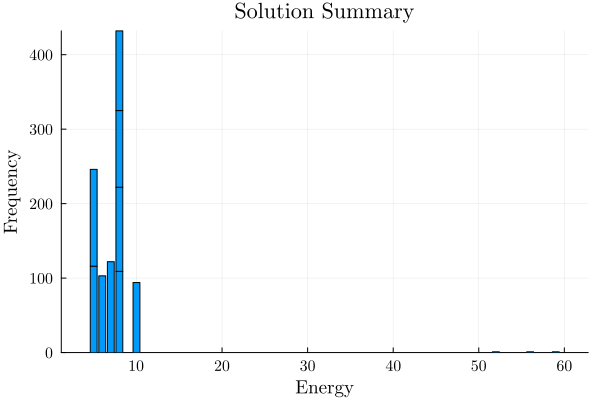

In [15]:
# plot(QUBOTools.EnergyFrequencyPlot(ising_model))
plot(QUBOTools.sampleset(unsafe_backend(ising_model)))

We are going to use the default limits of temperature given by the simulating annealing code. These are defined using the minimum and maximum nonzero coefficients in the Ising model. Then the range for beta is defined as 

$$
\beta \in \left[ \frac{\log(2)}{\max \{ \Delta E \} },\frac{\log(100)}{\min \{ \Delta E \} } \right]
$$

where

$$
\Delta E = \min_{i} \{h_i \} + \sum_j J_{ij}+J_{ji}
$$

Hot temperature: We want to scale hot_beta so that for the most unlikely qubit flip, we get at least 50% chance of flipping. (This means all other qubits will have > 50% chance of flipping initially). Most unlikely flip is when we go from a very low energy state to a high energy state, thus we calculate hot_beta based on max_delta_energy.

$$
0.50 = \exp(-\overline{\beta} * \max \{ \Delta E \})
$$

Cold temperature: Towards the end of the annealing schedule, we want to minimize the chance of flipping. Don't want to be stuck between small energy tweaks. Hence, set cold_beta so that at minimum energy change, the chance of flipping is set to 1%.

$$
0.01 = \exp(-\underline{\beta} * \min \{ \Delta E \})
$$

By default, the schedule also follows a geometric series.

In [16]:
function geomspace(a, b; length = 100)
    return exp10.(range(log10(a), log10(b); length))
end

geomspace (generic function with 1 method)

In [17]:
# data = QUBOTools.metadata(QUBOTools.solution(qubo_model))
# info = data["info"]

β₀, β₁ = (2.0, 100.0) # info["beta_range"]

(2.0, 100.0)

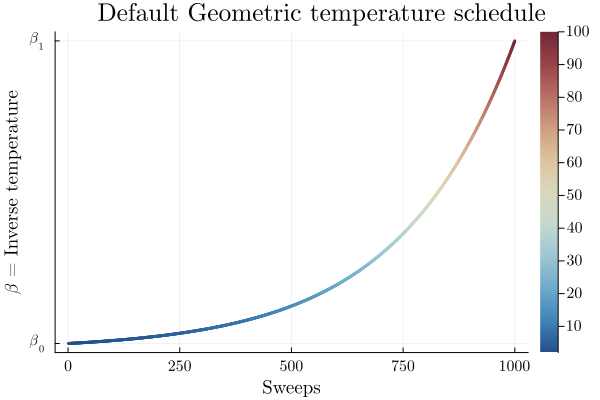

In [18]:
function plot_schedule(β₀, β₁; length = 1_000)
    β = geomspace(β₀, β₁; length=1_000)

    plt = plot(;
        plot_title = "Default Geometric temperature schedule",
        xlabel     = "Sweeps",
        ylabel     = raw"$ \beta $ = Inverse temperature",
        
    )

    plot!(
        plt, β;
        color     = cgrad(:redblue; rev=true),
        linestyle = :dot,
        linewidth = 3,
        line_z    = β,
        legend    = nothing,
        yticks    = ([β₀, β₁], [raw"$ \beta_{0} $", raw"$ \beta_{1} $"]),
    )

    return plt
end

plot_schedule(β₀, β₁)

In [19]:
sweeps    = [1:250; 260:10:1_000]
schedules = ["geometric", "linear"]

s = 0.99 # Success probability
λ⃰ = 5.0  # Optimal Energy \lambda[tab]\asteraccent[tab]

results = Dict{Symbol,Any}(
    :p   => Dict{String,Any}(), # Success probability
    :t   => Dict{String,Any}(), # Time elapsed
    :ttt => Dict{String,Any}(), # Time-to-target
)

set_attribute(ising_model, "num_reads", 1_000)

for schedule in schedules
    results[:p][schedule]   = Float64[]
    results[:t][schedule]   = Float64[]
    results[:ttt][schedule] = Float64[]

    set_attribute(ising_model, "beta_schedule_type", schedule)

    for sweep in sweeps
        set_attribute(ising_model, "num_sweeps", sweep)

        optimize!(ising_model)

        sol = QUBOTools.sampleset(unsafe_backend(ising_model))
        p   = QUBOTools.success_rate(sol, λ⃰)
        t   = QUBOTools.effective_time(sol) # TODO: Should be 'total_time'?
        ttt = QUBOTools.tts(sol, λ⃰, s)

        push!(results[:p][schedule], p)
        push!(results[:t][schedule], t)
        push!(results[:ttt][schedule], ttt)
    end
end

results

Dict{Symbol, Any} with 3 entries:
  :p   => Dict{String, Any}("geometric"=>[0.64, 0.507, 0.426, 0.397, 0.335, 0.3…
  :ttt => Dict{String, Any}("geometric"=>[0.0126028, 0.019915, 0.0227079, 0.026…
  :t   => Dict{String, Any}("geometric"=>[0.00279592, 0.00305847, 0.00273731, 0…

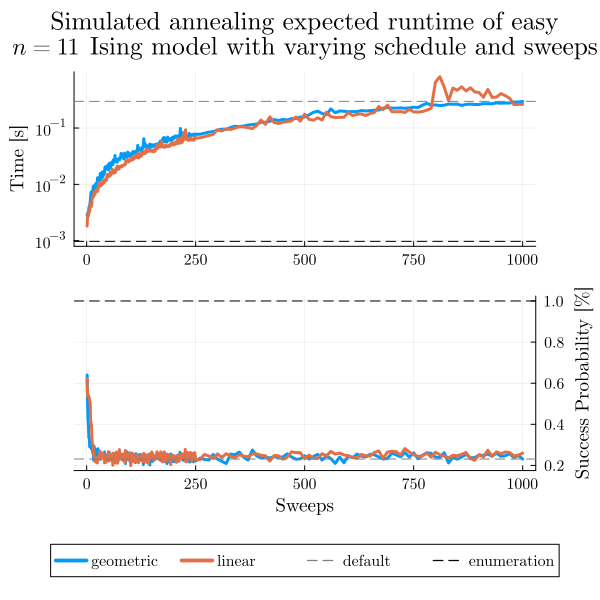

In [20]:
function plot_schedule_grid(sweeps, schedules, results)
    plt = plot(;
        layout     = @layout([a{0.475h}; b{0.475h}; leg{0.05h}]),
        size       = (600, 600),
        plot_title = raw"""
            Simulated annealing expected runtime of easy
            $ n = 11 $ Ising model with varying schedule and sweeps
            """,
        plot_titlevspan = 0.1,
    )

    # Elapsed time
    plot!(
        plt;
        subplot = 1,
        ylabel  = "Time [s]",
        yscale  = :log10,
        legend  = false,
    )

    for schedule in schedules
        plot!(
            plt, sweeps, results[:t][schedule];
            subplot   = 1,
            linestyle = :solid,
            label     = schedule,
            linewidth = 3,
        )
    end

    hline!(
        plt, [results[:t]["geometric"][end]];
        subplot   = 1,
        linestyle = :dash,
        label     = "default",
        color     = :gray,
        linewidth = 1,
    )

    hline!(
        plt, [enumeration_time];
        subplot    = 1,
        linestyle  = :dash,
        label      = "enumeration",
        color      = :black,
        linewidth  = 1,
    )

    # Success probability
    plot!(
        plt;
        subplot = 2,
        xlabel  = "Sweeps",
        ylabel  = "Success Probability [%]",
        legend  = false,
    )

    for schedule in schedules
        plot!(
            plt, sweeps, results[:p][schedule];
            subplot   = 2,
            linestyle = :solid,
            label     = schedule,
            ymirror   = true,
            linewidth = 3,
        )
    end
    
    hline!(
        plt, [results[:p]["geometric"][end]];
        subplot    = 2,
        linestyle  = :dash,
        label      = "default",
        color      = :gray,
        linewidth  = 1,
    )

    hline!(
        plt, [1.0];
        subplot    = 2,
        linestyle  = :dash,
        label      = "enumeration",
        color      = :black,
        linewidth  = 1,
    )

    # Legend
    plot!(
        plt, (1:4)';
        subplot       = 3,
        framestyle    = nothing,
        showaxis      = false,
        grid          = false,
        linestyle     = [:solid :solid :dash :dash],
        color         = [1 2 :gray :black],
        label         = ["geometric" "linear" "default" "enumeration"],
        linewidth     = [3 3 1 1],
        legend        = :top,
        legend_column = 4,
    )

    return plt
end

plot_schedule_grid(sweeps, schedules, results)

These plots represent often contradictory metrics: on one hand you would like to obtain a large probability of finding a right solution (the definition of right comes from what you define as success).
On the other hand, the time it takes to solve these cases should be as small as possible.
This is why we are interested in a metric that combines both, and that is why we settle on the Time To Solution (TTS) which is defined as

$$
TTS = \frac{\log{1-s}}{\log{1-p}}
$$

where s is a success factor, usually takes as $s = 99\%$, and $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within $99\%$ probability.

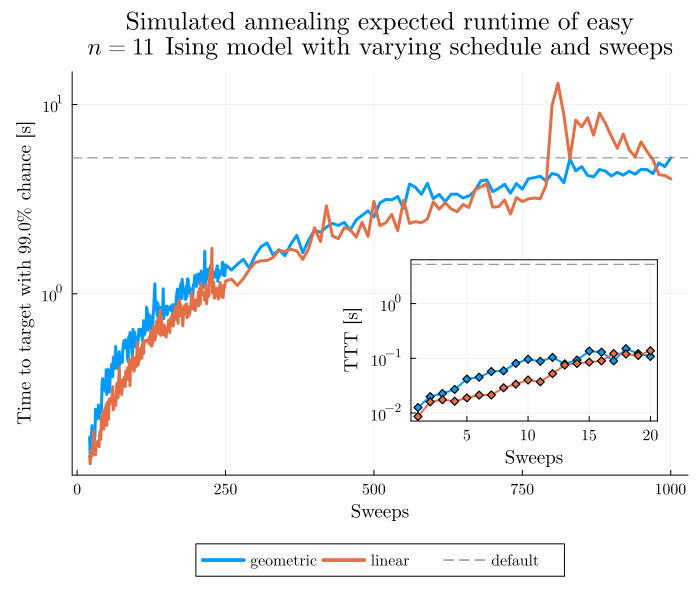

In [21]:
function plot_ttt_grid(sweeps, schedules, results, k = 20)
    
    plt = plot(;
        layout     = @layout([a{0.95h}; leg{0.05h}]),
        size       = (700, 600),
        plot_title = raw"""
            Simulated annealing expected runtime of easy
            $ n = 11 $ Ising model with varying schedule and sweeps
            """,
        plot_titlevspan = 0.1,
        plot_titlefont  = Plots.font(16, "Computer Modern"),
        titlefont       = Plots.font(14, "Computer Modern"),
        guidefont       = Plots.font(12, "Computer Modern"),
        legendfont      = Plots.font(10, "Computer Modern"),
        tickfont        = Plots.font(10, "Computer Modern"),
        inset_subplots  = [(1, bbox(0.25,0.166,0.4,0.4, :center))],
    )

    # Elapsed time
    plot!(
        plt;
        subplot = 1,
        xlabel  = "Sweeps",
        ylabel  = "Time to target with \$ $(100s) \\% \$ chance [s]",
        legend  = false,
        legend_column = 3,
    )

    for schedule in schedules
        plot!(
            plt, sweeps[k+1:end], results[:ttt][schedule][k+1:end];
            subplot   = 1,
            linestyle = :solid,
            label     = schedule,
            yscale    = :log10,
            linewidth = 3,
        )
    end

    # Value for the default solution
    hline!(
        plt, [results[:ttt]["geometric"][end]];
        subplot    = 1,
        linestyle  = :dash,
        label      = "default",
        color      = :gray,
        linewidth  = 1,
    )
    
    # Legend
    plot!(
        plt, (1:3)';
        subplot = 2,
        framestyle = nothing,
        showaxis   = false,
        grid       = false,
        linestyle  = [:solid :solid :dash],
        linewidth  = [3 3 1],
        color      = [1 2 :gray],
        label      = ["geometric" "linear" "default"],
        legend     = :top,
        legend_column = 3,
    )
    
    plot!(
        plt[3];
        xlabel     = "Sweeps",
        ylabel     = "TTT [s]",
        yscale     = :log10,
        legend     = false,
        framestyle = :box,

    )
    
    for schedule in schedules
        plot!(
            plt[3], sweeps[1:k], results[:ttt][schedule][1:k];
            linewidth  = 2,
            marker     = :diamond,
            markersize = 4,
        )
    end

    hline!(
        plt[3], [results[:ttt]["geometric"][end]];
        linestyle = :dash,
        color     = :gray,
        linewidth = 1,
    )

    return plt
end

plot_ttt_grid(sweeps, schedules, results)

As you can notice, the default parameters given by D-Wave (number of sweeps = $1000$ and a geometric update of $\beta$) are not optimal for our tiny example in terms of expected runtime.
This is certainly a function of the problem, for such a small instance having two sweeps are more than enough and more sweeps are an overkill.
This parameters choice might not generalize to any other problem, as seen below.

## Example 2
Let's define a larger model, with 100 variables and random weights, to see how this performance changes.

Assume that we are interested at the instance created with random weights $h_{i}, J_{i, j} \sim U[-1, +1]$.

In [22]:
using Random

In [23]:
# Number of variables
n = 100

# Fixing the random seed to get the same result
Random.seed!(1)

# We only consider upper triangular matrix ignoring the diagonal
J = triu!(2rand(Float64, n, n) .- 1, 1)
h = 2rand(Float64, n) .- 1

;

In [ ]:
plot(QUBOTools.SystemLayoutPlot(J + diagm(h)))

For a problem of this size we cannot do a complete enumeration ($2^{100} \approx 1.2e30$) but we can randomly sample the distribution of energies to have a baseline for our later comparisons.

In [25]:
random_ising_model = Model()

@variable(random_ising_model, s[1:n], Spin)

@objective(random_ising_model, Min, s' * J * s + h' * s)

random_ising_model

A JuMP Model
Minimization problem with:
Variables: 100
Objective function type: QuadExpr
`VariableRef`-in-`Spin`: 100 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: s

In [26]:
using Statistics

In [27]:
set_optimizer(random_ising_model, QUBO.RandomSampler.Optimizer)
set_attribute(random_ising_model, "num_reads", 1_000)

optimize!(random_ising_model)

random_sampling_time = solve_time(random_ising_model)

energies = [objective_value(random_ising_model; result = i) for i = 1:result_count(random_ising_model)]

random_mean_energy = mean(energies)

@info "Average random energy = $(random_mean_energy)"

┌ Info: Average random energy = 1.100341856327635
└ @ Main /mnt/c/Users/pedroxavier/QUBONotebooks/notebooks/5-Benchmarking.ipynb:12


In [28]:
set_optimizer(random_ising_model, DWaveNeal.Optimizer)
set_attribute(random_ising_model, "num_reads", 1_000)

optimize!(random_ising_model)

@info "Simulated Annealing best energy = $(objective_value(random_ising_model))"

┌ Info: Simulated Annealing best energy = -408.47197451530747
└ @ Main /mnt/c/Users/pedroxavier/QUBONotebooks/notebooks/5-Benchmarking.ipynb:6


Notice that the minimum energy coming from the random sampling and the one from the simulated annealing are very different. 
Moreover, the distributions that both lead to are extremely different too.

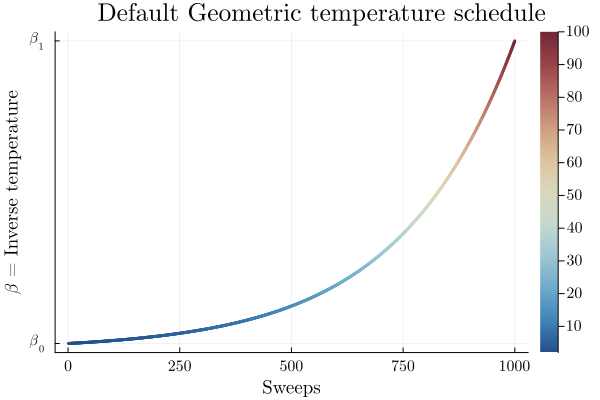

In [29]:
# data = QUBOTools.metadata(QUBOTools.solution(qubo_model))
# info = data["info"]

β₀, β₁ = (2.0, 100.0) # info["beta_range"]

plot_schedule(β₀, β₁)

We can solve this problem using IP such that we have guarantees that it is solved to optimality (this might be a great quiz for future lectures), but in this case let us define the "success" as getting an objective certain percentage of the best found solution in all cases (which we see it might not be even found with the default parameters).
To get a scaled version of this success equivalent for all instances, we will define this success with respect to the metric:

$$
\frac{\textrm{found} - \textrm{random}}{\textrm{minimum} - \textrm{random}}
$$

Where $\textrm{found}$ corresponds to the best found solution within our sampling, $\textrm{random}$ is the mean of the random sampling shown above, and $\textrm{minimum}$ corresponds to the best found solution to our problem during the exploration.
Consider that this minimum might not be the global minimum.
This metric is very informative given that the best performance you can have is $1$, being at the minimum, and negative values would correspond to a method that at best behaves worse that the random sampling.
Success now is counted as being within certain treshold of this value of $1$.
This new way of measuring each method is very similar to the approximation ratio of approximation algorithms, therefore we will use that terminology from now on.

Before figuring out if we have the right optimal parameters, we want to save some effort by loading previously computed results.
    If you do not want to load the results that we are providing, feel free to change the `overwrite_pickles` variable, at the expense that it will take some time (around 3 minutes per instance) to run.
    If you do not want to wait, drop the `results.zip` file in the folder that is about to be created.

In [18]:
pickle_path = joinpath(@__DIR__, "results")

if !isdir(pickle_path)
    @warn "Results directory '$pickle_path' does not exist. We will create it."

    mkpath(pickle_path)
end

┌ Warning: Results directory '/home/pedroxavier/gits/QUBO-notebooks/notebooks/results' does not exist. We will create it.
└ @ Main /home/pedroxavier/gits/QUBO-notebooks/notebooks/5-Benchmarking.ipynb:4


"/home/pedroxavier/gits/QUBO-notebooks/notebooks/results"

Put the file in there and we will decompress it for you.

In [ ]:
import zipfile

zip_name = joinpath(pickle_path, "results.zip")

overwrite_pickles = false
use_raw_data      = true

if isfile(zip_name) && use_raw_data
    run(`gzip -d $pickle_path`)

    @info("Results zip file has been extrated to '$pickle_path'")
end

Now either we have the pickled file or not, let us compute the statistics we are looking for.

In [ ]:
s         = 0.99  # This is the success probability for the ttt calculation
threshold = 5.0  # This is a percentual threshold of what the minimum energy should be

sweeps    = [1:250;260:10:1_000]
schedules = ["geometric", "linear"]

total_reads    = 1_000
default_sweeps = 1_000
n_boot         = 500
ci             = 68  # Confidence interval for bootstrapping
default_boots  = default_sweeps

boots = [1, 10, default_boots]

min_energy = -239.7094652034834

instance     = 42
results_name = "results_$(instance).json"
results_name = joinpath(pickle_path, results_name)
results = Dict{Symbol,Any}(
    :p             => Dict{Int,Any}(),
    :min_energy    => Dict{Int,Any}(),
    :random_energy => Dict{Int,Any}(),
    :ttt           => Dict{Int,Any}(),
    :tttci         => Dict{Int,Any}(),
    :t             => Dict{Int,Any}(),
    :best          => Dict{Int,Any}(),
    :bestci        => Dict{Int,Any}(),
)

# If you wanto to use the raw data and process it here
if use_raw_data || !isfile(results_name)
    # If you want to generate the data or load it here
    overwrite_pickles = false

    for boot in boots
        results[:p][boot]      = Dict{X,Any}()
        results[:ttt][boot]    = Dict{X,Any}()
        results[:tttci][boot]  = Dict{X,Any}()
        results[:best][boot]   = Dict{X,Any}()
        results[:bestci][boot] = Dict{X,Any}()
    end

    for schedule in schedules
        probs       = Dict{Int,Any}(k => [] for k in boots)
        time_to_sol = Dict{Int,Any}(k => [] for k in boots)
        prob_np     = Dict{Int,Any}(k => [] for k in boots)
        tttcs       = Dict{Int,Any}(k => [] for k in boots)
        times       = []
        b           = Dict{Int,Any}(k => [] for k in boots)
        bnp         = Dict{Int,Any}(k => [] for k in boots)
        bcs         = Dict{Int,Any}(k => [] for k in boots)

        for sweep in sweeps
            # Gather instance names
            pickle_name = joinpath(pickle_path, "$instance)_$(schedule)_$(sweep).p")

            # If the instance data exists, load the data
            if isfile(pickle_name) && !overwrite_pickles
                # print(pickle_name)
                sol    = QUBOTools.read_solution(pickle_name)
                time_s = QUBOTools.effective_time(sol)
            else # If it does not exist, generate the data
                set_attribute(random_ising_model, "num_reads", total_reads)
                set_attribute(random_ising_model, "num_sweeps", sweep)
                set_attribute(random_ising_model, "beta_schedule_type", schedule)

                optimize!(random_ising_model)

                sol = QUBOTools.solution(random_ising_model)
                QUBOTools.write_solution(pickle_name, sol)
            end

            # Compute statistics
            energies     = QUBOTools.value.(sol)
            occurrences  = QUBOTools.reads.(sol)
            total_counts = sum(occurrences)

            push!(times, time_s)
            
            if min(energies) < min_energy
                min_energy = min(energies)
                @info("A better solution of '$(min_energy)' was found for sweep '$sweep'")
            end

            # success = min_energy*(1.0 + threshold/100.0)**np.sign(min_energy)
            success = random_energy - (random_energy - min_energy)*(1.0 - threshold/100.0)

            # Best of boot samples es computed via n_boot bootstrappings
            boot_dist = Dict{Int,Any}()
            pr_dist   = Dict{Int,Any}()
            cilo = Dict{Int,Any}()
            ciup = Dict{Int,Any}()
            pr = Dict{Int,Any}()
            pr_cilo = Dict{Int,Any}()
            pr_ciup = Dict{Int,Any}()

            for boot in boots
                boot_dist[boot] = []
                pr_dist[boot]   = []

                for i in 1:n_boot
                    resampler   = rand(0:total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)

                    # Compute the best along that axis
                    push!(boot_dist[boot], min(sample_boot))

                    occurences = occurrences[resampler]
                    counts     = Dict{Float64,Int}() 

                    for (index, energy) in enumerate(sample_boot)
                        if energy in keys(counts)
                            counts[energy] += occurences[index]
                        else
                            counts[energy] = occurences[index]
                        end
                    end

                    push!(
                        pr_dist[boot],
                        sum(counts[key] for key in keys(counts) if key < success) / boot
                    )
                end

                push!(b[boot], mean(boot_dist[boot]))

                # Confidence intervals from bootstrapping the best out of boot
                bnp[boot]  = boot_dist[boot]
                cilo[boot] = map(x -> percentile(x, 50 - ci / 2), bnp[boot])
                ciup[boot] = map(x -> percentile(x, 50 + ci / 2), bnp[boot])

                push!(bcs[boot], (cilo[boot], ciup[boot]))

                # Confidence intervals from bootstrapping the ttt of boot
                prob_np[boot] = pr_dist[boot]
                pr[boot]      = mean(prob_np[boot])

                push!(probs[boot], pr[boot])

                if !all(x -> x > 0, prob_np[boot])
                    push!(time_to_sol[boot], Inf)
                    push!(tttcs[boot], (Inf, Inf))
                else
                    pr_cilo[boot] = map(x -> percentile(x, 50 - ci / 2), prob_np[boot])
                    pr_ciup[boot] = map(x -> percentile(x, 50 + ci / 2), prob_np[boot])
                    
                    push!(time_to_sol[boot], time_s * log10(1-s) / log10(1 - pr[boot] + 1E-9))
                    push!(
                        tttcs[boot],
                        (
                            time_s*log10(1-s)/log10(1 - pr_cilo[boot]),
                            time_s*log10(1-s)/log10(1 - pr_ciup[boot]+1E-9)
                        )
                    )
                end
            end
        end

        results[:t][schedule]             = times
        results[:min_energy][schedule]    = min_energy
        results[:random_energy][schedule] = random_energy

        for boot in boots
            results[:p][boot][schedule]     = probs[boot]
            results[:ttt][boot][schedule]   = time_to_sol[boot]
            results[:tttci][boot][schedule] = tttcs[boot]
            results[:best][boot][schedule]  = [
                (random_energy - energy) / (random_energy - min_energy)
                for energy in b[boot]
            ]
            results[:bestci][boot][schedule] = [
                tuple((random_energy - element) / (random_energy - min_energy) for element in energy)
                for energy in bcs[boot]
            ]
        end
    end

    # Save results file in case that we are interested in reusing them
    JSON.print(results_name, results)
else  # Just reload processed datafile
    results = JSON.parsefile(results_name)
end


After gathering all the results, we would like to see the progress of the approximation ratio with respect to the increasing number of sweeps. 
To account for the stochasticity of this method, we are bootstrapping all of our results with different values of the bootstrapping sample, and each confidence interval corresponds to a standard deviation away from the mean.

In [30]:
function plot_progress(sweeps, boots, schedules, results)
    plt = plot(;
        plot_title = """
            Simulated annealing approximation ratio of Ising 42 N=100
            with varying schedule, $(n_boot) bootstrap re-samples, and sweeps
            """,
        xscale     = :log10,
        # xlims      = (1, 200),
        ylims      = (0.8, 1.01),
        xlabel     = "Sweeps",
        ylabel     = raw"Approximation ratio = \
            $\frac{\textrm{best found} - \textrm{random sample}}\
            {\textrm{min energy} - \textrm{random sample}}$",
        legend     = :outertop,
    )


    for boot in boots
        for schedule in schedules
            bestnp = transpose(stack(results[:bestci][boot][schedule], dims=1))

            plot!(
                plt,
                sweeps, bestnp[0];
                fillrange = bestnp[1],
                fillalpha = 0.25,
            )

            plot!(
                plt,
                sweeps, results[:best][boot][schedule];
                label = "$schedule, $boot reads",
            )
        end
    end
end


plot_progress (generic function with 1 method)

Now, besides looking at the sweeps, which are our parameter, we want to see how the performance changes with respect to the number of shots, which in this case are proportional to the computational time/effort that it takes to solve the problem.

In [ ]:
fig, ax = plt.subplots()
for boot in boots:
    reads = [s * boot for s in sweeps]
    for schedule in schedules:
        ax.plot(reads, results['best'][boot][schedule], label=str(
            schedule) + ' with ' + str(boot) + ' reads')
        bestnp = np.stack(results['bestci'][boot][schedule], axis=0).T
        ax.fill_between(reads, bestnp[0], bestnp[1], alpha=0.25)
ax.set(xlabel='Total number of reads')
ax.set(ylabel='Approximation ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of Ising 42 N=100\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8, 1.01])
# ax.set(xlim=[1,200])


In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Simulated annealing expected runtime of \n' +
             ' instance ' + str(instance) + ' Ising N=100 with varying schedule and sweeps')

for schedule in schedules:
    ax1.plot(sweeps, results['t'][schedule], '-', label=schedule)
ax1.hlines(results['t']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(ylabel='Time [s]')
# ax1.set(xlim=[1,200])


for schedule in schedules:
    ax2.semilogy(sweeps, results['p'][default_sweeps]
                 [schedule], '-', label=schedule)
ax2.hlines(results['p'][default_sweeps]['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')
# ax2.set(xlim=[1,200])

ax2.set(ylabel='Success Probability \n (within ' +
        str(treshold) + ' % of best found)')
ax2.set(xlabel='Sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.3))


In [ ]:
fig1, ax1 = plt.subplots()

for boot in reversed(boots):
    for schedule in schedules:
        ax1.plot(sweeps, results['tts'][boot][schedule],
                 label=schedule + "_boot" + str(boot))
        ttsnp = np.stack(results['ttsci'][boot][schedule], axis=0).T
        ax1.fill_between(sweeps, ttsnp[0], ttsnp[1], alpha=0.25)


ax1.hlines(results['tts'][total_reads]['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(yscale='log')
ax1.set(ylim=[3, 1e3])
# ax1.set(xlim=[1,200])

ax1.set(ylabel='Time To Solution within ' +
        str(treshold) + ' % of best found [s]')
ax1.set(xlabel='Sweeps')
ax.set_title('Simulated annealing expected runtime of random Ising N=100\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
           ncol=2, fancybox=False, shadow=False)

ax2 = plt.axes([.45, .55, .4, .3])
for schedule in schedules:
    min_tts = min(results['tts'][default_sweeps][schedule])
    min_index = results['tts'][default_sweeps][schedule].index(min_tts)
    min_sweep = sweeps[results['tts'][default_sweeps][schedule].index(min_tts)]
    print("minimum TTS for " + schedule + " schedule = " +
          str(min_tts) + "s at sweep = " + str(min_sweep))
    ax2.semilogy(sweeps[min_index-10:min_index+10], results['tts']
                  [default_sweeps][schedule][min_index-10:min_index+10], '-s')
    ax2.hlines(results['tts'][default_sweeps]['geometric'][-1], sweeps[min_index-10], sweeps[min_index+10],
           linestyle='--', label='default', colors='b')

ax2.set(ylabel='TTS [s]')
ax2.set(xlabel='Sweeps')


In [ ]:
min_beta_schedule = np.geomspace(
    *simAnnSamplesDefault.info['beta_range'], num=min_sweep)
fig, ax = plt.subplots()
ax.plot(beta_schedule, '.')
ax.plot(min_beta_schedule, '.')
ax.set_xlabel('Sweeps')
ax.set_ylabel('beta=Inverse temperature')
ax.set_title('Geometric temperature schedule')
plt.legend(['Default', 'Best'])


In [ ]:
fig, ax = plt.subplots()
schedules = ['geometric']
# Best of boot samples es computed via n_boot bootstrapping
n_boot = 500
boots = range(1, 1000, 1)
interest_sweeps = [min_sweep, default_sweeps, 10, 500]
approx_ratio = dict()
approx_ratioci = dict()

for schedul in schedules:
    approx_ratio[schedule] = {}
    approx_ratioci[schedule] = {}

# Gather instance names
instance = 42
for sweep in interest_sweeps:
    for schedule in schedules:
        if sweep in approx_ratio[schedule].keys() and sweep in approx_ratioci[schedule].keys():
            pass
        else:
            min_energy = results['min_energy'][schedule]
            random_energy = results['random_energy'][schedule]

            pickle_name = str(instance) + "_" + schedule + \
                "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(
                    model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies = samples.data_vectors['energy']
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) +
                      " was found for sweep " + str(sweep))

            b = []
            bcs = []
            probs = []
            time_to_sol = []
            for boot in boots:
                boot_dist = []
                pr_dist = []
                for i in range(int(n_boot - boot + 1)):
                    resampler = np.random.randint(0, total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    boot_dist.append(min(sample_boot))

                b.append(np.mean(boot_dist))
                # Confidence intervals from bootstrapping the best out of boot
                bnp = np.array(boot_dist)
                cilo = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.-ci/2.)
                ciup = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.+ci/2.)
                bcs.append((cilo, ciup))

            approx_ratio[schedule][sweep] = [
                (random_energy - energy) / (random_energy - min_energy) for energy in b]
            approx_ratioci[schedule][sweep] = [tuple((random_energy - element) / (
                random_energy - min_energy) for element in energy) for energy in bcs]

        ax.plot([shot*sweep for shot in boots], approx_ratio[schedule]
                [sweep], label=str(sweep) + ' sweeps')
        approx_ratio_bestci_np = np.stack(
            approx_ratioci[schedule][sweep], axis=0).T
        ax.fill_between([shot*sweep for shot in boots],
                        approx_ratio_bestci_np[0], approx_ratio_bestci_np[1], alpha=0.25)
ax.set(xscale='log')
ax.set(ylim=[0.9, 1.01])
ax.set(xlim=[1e2, 1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Approximation ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of Ising ' + str(instance) + ' N=100\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()


Here see how using the optimal number of sweeps is better than using other values (including the default recommended by the solver) in terms of solving this problem.
Obviously, we only know this after running the experiments and verifying it ourselves.
This is not the usual case, so we want to see how well can we do if we solve similar (but no the same instances).
Here we will generate 20 random instances from the same distribution and size but different random seed. 

In [ ]:
overwrite_pickles = False
s = 0.99  # This is the success probability for the TTS calculation
treshold = 5.0  # This is a percentual treshold of what the minimum energy should be
sweeps = list(chain(np.arange(1, 250, 1), np.arange(250, 1001, 10)))
# schedules = ['geometric', 'linear']
schedules = ['geometric']
total_reads = 1000
default_sweeps = 1000
# boots = [1, 10, 100, default_sweeps]
boots = [1, 10, default_boots]
all_results = {}
instances = range(20)
use_raw_data = False

all_results_name = "all_results.pkl"
all_results_name = os.path.join(pickle_path, all_results_name)
# If you wanto to use the raw data and process it here
if use_raw_data or not(os.path.exists(all_results_name)):

    for instance in instances:
        all_results[instance] = {}
        all_results[instance]['p'] = {}
        all_results[instance]['min_energy'] = {}
        all_results[instance]['random_energy'] = {}
        all_results[instance]['tts'] = {}
        all_results[instance]['ttsci'] = {}
        all_results[instance]['t'] = {}
        all_results[instance]['best'] = {}
        all_results[instance]['bestci'] = {}

        # Fixing the random seed to get the same result
        np.random.seed(instance)
        J = np.random.rand(N, N)
        # We only consider upper triangular matrix ignoring the diagonal
        J = np.triu(J, 1)
        h = np.random.rand(N)
        model_random = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)

        randomSample = randomSampler.sample(
            model_random, num_reads=total_reads)
        random_energies = [datum.energy for datum in randomSample.data(
            ['energy'])]
        random_energy = np.mean(random_energies)

        default_pickle_name = str(instance) + "_geometric_1000.p"
        default_pickle_name = os.path.join(pickle_path, default_pickle_name)
        if os.path.exists(default_pickle_name) and not overwrite_pickles:
            simAnnSamplesDefault = pickle.load(open(default_pickle_name, "rb"))
            timeDefault = simAnnSamplesDefault.info['timing']
        else:
            start = time.time()
            simAnnSamplesDefault = simAnnSampler.sample(
                model_random, num_reads=1000)
            timeDefault = time.time() - start
            simAnnSamplesDefault.info['timing'] = timeDefault
            pickle.dump(simAnnSamplesDefault, open(default_pickle_name, "wb"))
        energies = [datum.energy for datum in simAnnSamplesDefault.data(
            ['energy'], sorted_by='energy')]
        min_energy = energies[0]
        for schedule in schedules:

            all_results[instance]['t'][schedule] = {}
            all_results[instance]['min_energy'][schedule] = {}
            all_results[instance]['random_energy'][schedule] = {}
            all_results[instance]['p'][schedule] = {}
            all_results[instance]['tts'][schedule] = {}
            all_results[instance]['ttsci'][schedule] = {}
            all_results[instance]['best'][schedule] = {}
            all_results[instance]['bestci'][schedule] = {}

            # probs = []
            probs = {k: [] for k in boots}
            time_to_sol = {k: [] for k in boots}
            prob_np = {k: [] for k in boots}
            ttscs = {k: [] for k in boots}
            times = []
            b = {k: [] for k in boots}
            bnp = {k: [] for k in boots}
            bcs = {k: [] for k in boots}
            for sweep in sweeps:
                # Gather instance names
                pickle_name = str(instance) + "_" + \
                    schedule + "_" + str(sweep) + ".p"
                pickle_name = os.path.join(pickle_path, pickle_name)
                # If the instance data exists, load the data
                if os.path.exists(pickle_name) and not overwrite_pickles:
                    samples = pickle.load(open(pickle_name, "rb"))
                    time_s = samples.info['timing']
                # If it does not exist, generate the data
                else:
                    start = time.time()
                    samples = simAnnSampler.sample(
                        model_random, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
                    time_s = time.time() - start
                    samples.info['timing'] = time_s
                    pickle.dump(samples, open(pickle_name, "wb"))
                # Compute statistics
                energies = samples.data_vectors['energy']
                occurrences = samples.data_vectors['num_occurrences']
                total_counts = sum(occurrences)
                times.append(time_s)
                if min(energies) < min_energy:
                    min_energy = min(energies)
                    # print("A better solution of " + str(min_energy) + " was found for sweep " + str(sweep))
                # success = min_energy*(1.0 + treshold/100.0)**np.sign(min_energy)
                success = random_energy - \
                    (random_energy - min_energy)*(1.0 - treshold/100.0)

                # Best of boot samples es computed via n_boot bootstrapping
                ci = 68
                boot_dist = {}
                pr_dist = {}
                cilo = {}
                ciup = {}
                pr = {}
                pr_cilo = {}
                pr_ciup = {}
                for boot in boots:
                    boot_dist[boot] = []
                    pr_dist[boot] = []
                    for i in range(int(n_boot)):
                        resampler = np.random.randint(0, total_reads, boot)
                        sample_boot = energies.take(resampler, axis=0)
                        # Compute the best along that axis
                        boot_dist[boot].append(min(sample_boot))

                        occurences = occurrences.take(resampler, axis=0)
                        counts = {}
                        for index, energy in enumerate(sample_boot):
                            if energy in counts.keys():
                                counts[energy] += occurences[index]
                            else:
                                counts[energy] = occurences[index]
                        pr_dist[boot].append(
                            sum(counts[key] for key in counts.keys() if key < success)/boot)
                    prob_np[boot] = np.array(pr_dist[boot])
                    pr[boot] = np.mean(prob_np[boot])
                    probs[boot].append(pr[boot])

                    b[boot].append(np.mean(boot_dist[boot]))
                    # Confidence intervals from bootstrapping the best out of boot
                    bnp[boot] = np.array(boot_dist[boot])
                    cilo[boot] = np.apply_along_axis(
                        stats.scoreatpercentile, 0, bnp[boot], 50.-ci/2.)
                    ciup[boot] = np.apply_along_axis(
                        stats.scoreatpercentile, 0, bnp[boot], 50.+ci/2.)
                    bcs[boot].append((cilo[boot], ciup[boot]))
                    # Confidence intervals from bootstrapping the TTS of boot
                    if prob_np[boot].all() == 0:
                        time_to_sol[boot].append(np.inf)
                        ttscs[boot].append((np.inf, np.inf))
                    else:
                        pr_cilo[boot] = np.apply_along_axis(
                            stats.scoreatpercentile, 0, prob_np[boot], 50.-ci/2.)
                        pr_ciup[boot] = np.apply_along_axis(
                            stats.scoreatpercentile, 0, prob_np[boot], 50.+ci/2.)
                        time_to_sol[boot].append(
                            time_s*math.log10(1-s)/math.log10(1-pr[boot]+1e-9))
                        ttscs[boot].append((time_s*math.log10(1-s)/math.log10(
                            1-pr_cilo[boot]+1e-9), time_s*math.log10(1-s)/math.log10(1-pr_ciup[boot]+1e-9)))

            all_results[instance]['t'][schedule][default_boots] = times
            all_results[instance]['min_energy'][schedule][default_boots] = min_energy
            all_results[instance]['random_energy'][schedule][default_boots] = random_energy
            for boot in boots:
                all_results[instance]['p'][schedule][boot] = probs[boot]
                all_results[instance]['tts'][schedule][boot] = time_to_sol[boot]
                all_results[instance]['ttsci'][schedule][boot] = ttscs[boot]
                all_results[instance]['best'][schedule][boot] = [
                    (random_energy - energy) / (random_energy - min_energy) for energy in b[boot]]
                all_results[instance]['bestci'][schedule][boot] = [tuple(
                    (random_energy - element) / (random_energy - min_energy) for element in energy) for energy in bcs[boot]]

    # Save results file in case that we are interested in reusing them
    pickle.dump(all_results, open(all_results_name, "wb"))
else:  # Just reload processed datafile
    all_results = pickle.load(open(all_results_name, "rb"))


In [ ]:
def bootstrap(data, n_boot=1000, ci=68):
    boot_dist = []
    for i in range(int(n_boot)):
        resampler = np.random.randint(0, data.shape[0], data.shape[0])
        sample = data.take(resampler, axis=0)
        # Median ignoring nans instead of mean
        boot_dist.append(np.nanmedian(sample, axis=0))
    b = np.array(boot_dist)
    s1 = np.apply_along_axis(stats.scoreatpercentile, 0, b, 50.-ci/2.)
    s2 = np.apply_along_axis(stats.scoreatpercentile, 0, b, 50.+ci/2.)
    return (s1, s2)


def tsplotboot(ax, x, data, error_est, **kw):
    if x is None:
        x = np.arange(data.shape[1])
    # Median ignoring nans instead of mean
    est = np.nanmedian(data, axis=0)
    mask = ~np.isnan(est)
    if error_est == 'bootstrap':
        cis = bootstrap(data)
    elif error_est == 'std':
        sd = np.nanstd(data, axis=0)
        cis = (est - sd, est + sd)
    ax.fill_between(x[mask], cis[0][mask], cis[1][mask], alpha=0.35, **kw)
    ax.plot(x[mask], est[mask], **kw)
    ax.margins(x=0)


Now we bootstrap our solutions with respect to the whole set of isntances, or ensemble, and we use the median which respresents the solution better than the mean.

In [ ]:
fig, ax1 = plt.subplots()
for boot in reversed(boots):
    for schedule in schedules:
        results_array = np.array(
            [np.array(all_results[i]['tts'][schedule][boot]) for i in range(20)])
        tsplotboot(ax1, x=np.asarray(sweeps), data=results_array, error_est='bootstrap',
                   label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')

        ax1.plot(sweeps, results['tts'][boot][schedule],
                 label="Instance " + schedule + "_boot" + str(boot))


ax1.set(yscale='log')

ax1.set(ylabel='Time To Solution within ' +
        str(treshold) + ' % of best found [s]')
ax1.set(xlabel='Sweeps')
plt.title('Simulated annealing expected runtime of \n' +
          ' Ising 42 N=100 with varying schedule and sweeps')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
           ncol=3, fancybox=False, shadow=False)

ax2 = plt.axes([.45, .55, .4, .3])
for schedule in schedules:
    results_array = np.array(
        [np.array(all_results[i]['tts'][schedule][default_boots]) for i in range(20)])
    min_median_tts = min(np.nanmedian(results_array, axis=0))
    min_median_index = np.argmin(np.nanmedian(results_array, axis=0))
    min_median_sweep = sweeps[min_median_index]
    min_tts = min(results['tts'][default_boots][schedule])
    min_index = results['tts'][default_boots][schedule].index(min_tts)
    min_sweep = sweeps[results['tts'][default_boots][schedule].index(min_tts)]
    if min_sweep < min_median_sweep:
        index_lo = min_index
        index_hi = min_median_index
    else:
        index_lo = min_median_index
        index_hi = min_index
    print("minimum median TTS for " + schedule + " schedule = " +
          str(min_median_tts) + "s at sweep = " + str(min_median_sweep))
    ax2.semilogy(sweeps[index_lo-5:index_hi+5],
                 np.median([all_results[i]['tts'][schedule][default_boots]
                           for i in range(20)], axis=0)
                 [index_lo-5:index_hi+5], '-s')
    print("minimum TTS for instance 42 with " + schedule +
          " schedule = " + str(min_tts) + "s at sweep = " + str(min_sweep))
    ax2.semilogy(sweeps[index_lo-5:index_hi+5],
                 results['tts'][default_sweeps][schedule][index_lo-5:index_hi+5], '-s')


ax2.hlines(np.median([all_results[i]['tts'][schedule][default_sweeps][-1] for i in range(20)]),
           sweeps[index_lo-5], sweeps[index_hi+5],
           linestyle='--', label='default', colors='b')

ax2.set(ylabel='TTS [s]')
ax2.set(xlabel='Sweeps')


In [ ]:
fig, ax = plt.subplots()
for boot in boots:
    for schedule in schedules:
        best_array = np.array(
            [np.array(all_results[i]['best'][schedule][boot]) for i in range(20)])
        # min_median_best = min(np.nanmedian(results_array, axis=0))
        tsplotboot(ax, x=np.asarray(sweeps), data=best_array, error_est='bootstrap',
                   label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')
ax.set(xlabel='Sweeps')
ax.set(ylabel='Approximation ratio \n = best found / min energy')
ax.set_title('Simulated annealing approximation ratio of \n' +
             ' Ensemble of Ising N=100 with varying schedule, sweeps, and number of reads')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8, 1.01])
# ax.set(xlim=[1,200])


In [ ]:
fig, ax = plt.subplots()
for boot in boots:
    reads = [s * boot for s in sweeps]
    for schedule in schedules:
        best_array = np.array(
            [np.array(all_results[i]['best'][schedule][boot]) for i in range(20)])
        # min_median_best = min(np.nanmedian(results_array, axis=0))
        tsplotboot(ax, x=np.asarray(reads), data=best_array, error_est='bootstrap',
                   label="Ensemble " + schedule + ' with ' + str(boot) + ' reads')
ax.set(xlabel='Total number of reads')
ax.set(ylabel='Approximation ratio \n = best found / min energy')
ax.set_title('Simulated annealing approximation ratio of \n' +
             ' Ensemble of Ising N=100 with varying schedule, sweeps, and number of reads')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8, 1.01])
# ax.set(xlim=[1,200])


In [ ]:
fig, ax = plt.subplots()
instances = np.arange(20)
default_boots = 1000
indices = [np.argmin(all_results[i]['tts']['geometric']
                     [default_boots]) for i in range(20)]
min_sweeps = [sweeps[i] for i in indices]
print('Optimal sweeps for each instance ' + str(min_sweeps))
minima = [np.min(all_results[i]['tts']['geometric'][default_boots])
          for i in range(20)]
default = [all_results[i]['tts']['geometric'][default_sweeps][-1]
           for i in range(20)]
median_all = [all_results[i]['tts']['geometric']
              [default_boots][min_median_index] for i in range(20)]


ax.bar(instances-0.2, minima, width=0.2, color='b',
       align='center', label='virtual best')
ax.bar(instances, median_all, width=0.2,
       color='g', align='center', label='median')
ax.bar(instances+0.2, default, width=0.2,
       color='r', align='center', label='default')
ax.xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('Instance')
ax.set(ylabel='Time To Solution within ' +
       str(treshold) + ' % of best found [s]')
plt.legend()


Notice how much performance would we be losing if we had used the default value for all these instances, and how much we could eventually win if we knew the best for each.

In [ ]:
fig, ax = plt.subplots()
interest_sweeps = [min_sweep, total_reads, 10, 500]
interest_sweeps.append(min_median_sweep)
interest_sweeps.append(120)
shots = range(1, 1000, 1)
n_boot = 100

# Gather instance names
instance = 42
for sweep in interest_sweeps:
    for schedule in schedules:
        if sweep in approx_ratio[schedule] and sweep in approx_ratioci[schedule]:
            pass
        else:
            min_energy = results['min_energy'][schedule]
            random_energy = results['random_energy'][schedule]

            pickle_name = str(instance) + "_" + schedule + "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(
                    model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies = samples.data_vectors['energy']
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) +
                    " was found for sweep " + str(sweep))
                results['min_energy'][schedule] = min_energy

            b = []
            bcs = []
            probs = []
            time_to_sol = []
            for shot in shots:
                shot_dist = []
                pr_dist = []
                for i in range(int(n_boot - shot + 1)):
                    resampler = np.random.randint(0, total_reads, shot)
                    sample_shot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    shot_dist.append(min(sample_shot))

                b.append(np.mean(shot_dist))
                # Confidence intervals from bootstrapping the best out of shot
                bnp = np.array(shot_dist)
                cilo = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.-ci/2.)
                ciup = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.+ci/2.)
                bcs.append((cilo, ciup))

            approx_ratio[schedule][sweep] = [
                (random_energy - energy) / (random_energy - min_energy) for energy in b]
            approx_ratioci[schedule][sweep] = [tuple((random_energy - element) / (
                random_energy - min_energy) for element in energy) for energy in bcs]

        ax.plot([shot*sweep for shot in shots], approx_ratio[schedule]
                [sweep], label=str(sweep) + ' sweeps')
        approx_ratio_bestci_np = np.stack(
            approx_ratioci[schedule][sweep], axis=0).T
        ax.fill_between([shot*sweep for shot in shots],
                        approx_ratio_bestci_np[0], approx_ratio_bestci_np[1], alpha=0.25)
ax.set(xscale='log')
ax.set(ylim=[0.95, 1.001])
ax.set(xlim=[1e2, 1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Approximation ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of Ising ' + str(instance) + ' N=100\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()


This example shows that for our beloved instance 42, using the mean of the best accross the ensemble is better than using the default, but not as good as if we knew from scratch what would have made the best case.

After figuring out what would be the best parameter for our instance of interest, it would be nice to see what the ensemble performance is.
We have several choices, either going with the (arbitrary) default values, or using the mean of the best performance we have found up to that point.
There is an unachievable goal, which would be the case where we knew the best solution of each case, which we call the virtual best.
This helps us understand how much is at stake with the choice of parameters we make.

In [ ]:
fig, ax = plt.subplots()
default_sweeps = 1000
interest_sweeps = [min_median_sweep, default_sweeps]
interest_sweeps.append('best')
# Careful, this cell is particularly expensive, so try it with n_boot = 100
n_boot = 100
overwrite_pickles = False


all_approx_ratio = {}

# Gather instance names
for instance in instances:
    all_approx_ratio[instance] = {}
    for schedul in schedules:
        all_approx_ratio[instance][schedule] = {}

    for sweep in interest_sweeps:
        flag_best = False
        if sweep == 'best':
            sweep = sweeps[indices[instance]]
            flag_best = True
        for schedule in schedules:
            if sweep in all_approx_ratio[instance][schedule]:
                pass
            else:
                min_energy = all_results[instance]['min_energy'][schedule][default_sweeps]
                random_energy = all_results[instance]['random_energy'][schedule][default_sweeps]

                pickle_name = str(instance) + "_" + \
                    schedule + "_" + str(sweep) + ".p"
                pickle_name = os.path.join(pickle_path, pickle_name)
                # If the instance data exists, load the data
                if os.path.exists(pickle_name) and not overwrite_pickles:
                    # print(pickle_name)
                    samples = pickle.load(open(pickle_name, "rb"))
                    time_s = samples.info['timing']
                # If it does not exist, generate the data
                else:
                    start = time.time()
                    samples = simAnnSampler.sample(
                        model_random, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                    time_s = time.time() - start
                    samples.info['timing'] = time_s
                    pickle.dump(samples, open(pickle_name, "wb"))
                # Compute statistics
                energies = samples.data_vectors['energy']
                if min(energies) < min_energy:
                    min_energy = min(energies)
                    # print("A better solution of " + str(min_energy) +
                    #       " was found for sweep " + str(sweep))

                b = []
                for shot in shots:
                    shot_dist = []
                    for i in range(int(n_boot - shot + 1)):
                        resampler = np.random.randint(0, total_reads, shot)
                        sample_shot = energies.take(resampler, axis=0)
                        # Compute the best along that axis
                        shot_dist.append(min(sample_shot))

                    b.append(np.mean(shot_dist))
            if flag_best:
                all_approx_ratio[instance][schedule]['best'] = [
                    (random_energy - energy) / (random_energy - min_energy) for energy in b]
                ax.plot([shot*sweep for shot in shots], all_approx_ratio[instance]
                        [schedule]['best'], color='lightgray', label=None, alpha=0.5)
            else:
                all_approx_ratio[instance][schedule][sweep] = [
                    (random_energy - energy) / (random_energy - min_energy) for energy in b]
                ax.plot([shot*sweep for shot in shots], all_approx_ratio[instance]
                        [schedule][sweep], color='lightgray', label=None, alpha=0.25)

for sweep in interest_sweeps:
    approx_ratio_array = np.array(
        [np.array(all_approx_ratio[i][schedule][sweep]) for i in instances])
    label_plot = "Ensemble " + schedule + ' with ' + str(sweep) + ' sweeps'
    if sweep == 'best':
        sweep = sweeps[indices[instance]]
        label_plot = "Ensemble " + schedule + ' with virtual best sweeps'
    reads = [shot*sweep for shot in shots]
    tsplotboot(ax, x=np.asarray(reads), data=approx_ratio_array,
               error_est='bootstrap', label=label_plot)

ax.set(xscale='log')
ax.set(ylim=[0.95, 1.001])
ax.set(xlim=[1e2, 1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Approximation ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of Ising Ensemble N=100\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()


As you can see, there is a gap between the case with the best mean performance and the virtual best. This difference is arguably small, but you can imagine that with a larger number of parameters, this difference can become larger and larger, making the search of good parameters more worthy and complicated. We are actively working on such parameter setting strategies, and expect to make progress in this area (keep tuned!).